See if we can somehow get CIVdist for subsamples of quasars to corelate with luminosity, or if we can find some kind of correction to beat down the scatter.  Really we can use anything from the SDSS catalog -- just **NO X-ray data!**  Although it might be useful to find things that correlate with useful x-ray props and reverse-engineer that to a point where x-ray is no longer needed (in another notebook).

I'm just going to keep this simple: remove dust-reddened objects, and colorcode by basically everything to see what we're working with.

In [1]:
#import necessary packages
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from astropy.stats import sigma_clip
import matplotlib.mlab as mlab
import sys
sys.path.append("/Users/Trevor1/Desktop/git/CIV_Distance/") #wherever CIV distance repo is saved
#sys.path.append("/Users/trevormccaffrey/Desktop/git/CIV_Distance/")
from CIVfunctions import project,CIV_distance

#Default MPL colorcycle
mplcol = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
#Need to work with fits table to read in ugriz array
tbl = Table.read('/Users/Trevor1/Desktop/data/files/catalogs/Rankine20_CIV_HeII_wDelGI_wCIVDist_ugriz.fits', format='fits')
ugriz_all = np.array(tbl["PSFMAG"])
ugriz_err_all = np.array(tbl["ERR_PSFMAG"])

In [3]:
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
dat = tbl[names].to_pandas()
#dat_full = tbl[names].to_pandas()

#dat = pd.read_csv("/Users/Trevor1/Desktop/data/files/catalogs/Rankine20_CIV_HeII_wDelGI_wCIVDist.csv")
print("Original Data: %d objects" % dat.shape[0])
dat.head()

Original Data: 145946 objects


SDSS_NAME         RA       Dec  col1    z_paul   good   nBAL  \
0  b"b'00000-00000'"  37.878914 -5.979054  3390  1.978870   True  False   
1  b"b'00000-00000'"  37.681328 -4.705002  3391  1.658950  False  False   
2  b"b'00000-00000'"  38.413724 -5.005835  8575  1.650225   True  False   
3  b"b'00000-00000'"  37.484777 -5.040745  8576  1.682022   True  False   
4  b"b'00000-00000'"  36.424650 -5.592339  8577  1.653923   True  False   

     AIi    BIi     CIV_blue  ...  FUV  FUV_IVAR  NUV  NUV_IVAR  FIRST_FLUX  \
0   True  False  -494.607254  ...  NaN       NaN  NaN       NaN        -1.0   
1   True  False   170.299612  ...  NaN       NaN  NaN       NaN        -1.0   
2   True  False  1458.723050  ...  NaN       NaN  NaN       NaN        -1.0   
3  False   True   573.970534  ...  NaN       NaN  NaN       NaN        -1.0   
4  False   True   992.493501  ...  NaN       NaN  NaN       NaN        -1.0   

   FIRST_SNR Delta_G_I  Separation_2  CIV_Distance Separation  
0       -1.0     0.257      0.000570      0.446845        0.0  
1       -1.0     0.870      0.001706      0.641868        0.0  
2       -1.0    -0.274      0.000398      0.695980        0.0  
3       -1.0     0.322      0.000842      0.595771        0.0  
4       -1.0     0.413      0.001466      0.323098        0.0  

[5 rows x 64 columns]

First just visualize the impact each successive cut has

* Remove dust-reddened objects: $\Delta(g-i) < 0.3$ (maybe should be absolute value?)
* Remove RL sources -- safe to consider all FIRST detections as RL (or at least very close to being RL).  In fact we might want to be more robust in removing RL sources at high-$z$ that remain undetected by FIRST.

In [4]:
good   = dat["good"].values
Mi     = dat["MI"].values
del_gi = dat["Delta_G_I"].values
clean  = good & ((Mi<0)&(Mi>-32)) & ((del_gi>-0.3)&(del_gi<0.3))
clean2 = good & ((Mi<0)&(Mi>-32))
d      = 3.08e19 #cm; =10pc
L2500  = -0.4*( Mi + 48.60 + np.log10(1+2) ) + np.log10(4*np.pi*(d**2)) #Eq 4 from Richards+ 2006, QLF paper

blue   = dat["CIV_blue"].values
ew     = dat["CIV_EW"].values
z      = dat["z_paul"].values
logEW  = np.log10(ew)
HeIIEW = dat["HeII_EW"].values
CIVdist= dat["CIV_Distance"].values
first  = dat["FIRST_FLUX"].values!=-1.0

<ipython-input-4-7579dbd07038>:12: RuntimeWarning: divide by zero encountered in log10
  logEW  = np.log10(ew)
<ipython-input-4-7579dbd07038>:12: RuntimeWarning: invalid value encountered in log10
  logEW  = np.log10(ew)


In [5]:
dat.columns

Index(['SDSS_NAME', 'RA', 'Dec', 'col1', 'z_paul', 'good', 'nBAL', 'AIi',
       'BIi', 'CIV_blue', 'CIV_EW', 'HeII_EW', 'THING_ID', 'PLATE', 'MJD',
       'FIBERID', 'SPECTRO', 'Z', 'Z_ERR', 'SOURCE_Z', 'Z_VI', 'Z_PIPE',
       'Z_PIPE_ERR', 'ZWARNING', 'Z_PCA', 'Z_PCA_ER', 'Z_MGII', 'BOSS_TARGET1',
       'ANCILLARY_TARGET1', 'ANCILLARY_TARGET2', 'EBOSS_TARGET0',
       'EBOSS_TARGET1', 'EBOSS_TARGET2', 'N_SPEC_SDSS', 'N_SPEC_BOSS',
       'N_SPEC', 'BI_CIV', 'ERR_BI_CIV', 'RUN_NUMBER', 'RERUN_NUMBER',
       'COL_NUMBER', 'FIELD_NUMBER', 'OBJ_ID', 'MI', 'RASS_COUNTS',
       'RASS_COUNTS_SNR', 'SDSS2ROSAT_SEP', 'FLUX_0.2_2.0keV',
       'FLUX_0.2_2.0keV_ERR', 'FLUX_2.0_12.0keV', 'FLUX_2.0_12.0keV_ERR',
       'FLUX_0.2_12.0keV', 'FLUX_0.2_12.0keV_ERR', 'LUM_0.2_12.0keV', 'FUV',
       'FUV_IVAR', 'NUV', 'NUV_IVAR', 'FIRST_FLUX', 'FIRST_SNR', 'Delta_G_I',
       'Separation_2', 'CIV_Distance', 'Separation'],
      dtype='object')

In [6]:
dat["FIRST_FLUX"]

0        -1.0
1        -1.0
2        -1.0
3        -1.0
4        -1.0
         ... 
145941   -1.0
145942   -1.0
145943   -1.0
145944   -1.0
145945   -1.0
Name: FIRST_FLUX, Length: 145946, dtype: float64

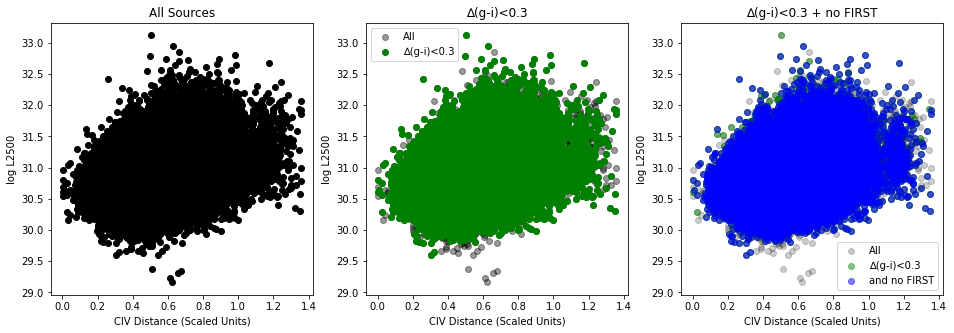

Number of Sources
All:                   140934
∆(g-i)<0.3:            121692
∆(g-i)<0.3 + no FIRST: 118259


In [7]:
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(16,5))

#Plot all objects
ax1.scatter(CIVdist[clean2], L2500[clean2], color="k")
ax1.set_xlabel("CIV Distance (Scaled Units)")
ax1.set_ylabel("log L2500")
ax1.set_title("All Sources")

#Remove dust-reddened sources
ax2.scatter(CIVdist[clean2], L2500[clean2], alpha=0.4, color="k", label="All")
ax2.scatter(CIVdist[clean], L2500[clean], color="g", label="∆(g-i)<0.3")
ax2.set_xlabel("CIV Distance (Scaled Units)")
ax2.set_ylabel("log L2500")
ax2.set_title("∆(g-i)<0.3")
ax2.legend(loc="best")

ax3.scatter(CIVdist[clean2], L2500[clean2], alpha=0.2, color="k", label="All")
ax3.scatter(CIVdist[clean], L2500[clean], alpha=0.45, color="g", label="∆(g-i)<0.3")
ax3.scatter(CIVdist[clean&~first], L2500[clean&~first], alpha=0.5, color="b", label="and no FIRST")
ax3.set_xlabel("CIV Distance (Scaled Units)")
ax3.set_ylabel("log L2500")
ax3.set_title("∆(g-i)<0.3 + no FIRST")
ax3.legend(loc="best")
plt.show()

print("Number of Sources")
print("All:                   %5d" % clean2.sum())
print("∆(g-i)<0.3:            %5d" % clean.sum())
print("∆(g-i)<0.3 + no FIRST: %5d" % (clean&~first).sum())

Cuts definitely make an impact.  Hard to see the full impact from these, but note that there are some clear selection effects in the distribution, i.e., the fraction of low-luminosity sources is inflated by the more sources at lower redshift (see redshift plots below).

In [8]:
#Only keep measurements Amy R counts as "good" - and define our full "clean" sample
dat    = dat[clean&(~first)]
ugriz  = ugriz_all[clean&(~first)]
ugriz_e= ugriz_err_all[clean&(~first)]

Mi     = dat["MI"].values
d      = 3.08e19 #cm; =10pc
L2500  = -0.4*( Mi + 48.60 + np.log10(1+2) ) + np.log10(4*np.pi*(d**2)) #Eq 4 from Richards+ 2006, QLF paper
del_gi = dat["Delta_G_I"].values
blue   = dat["CIV_blue"].values
ew     = dat["CIV_EW"].values
z      = dat["z_paul"].values
logEW  = np.log10(ew)
HeIIEW = dat["HeII_EW"].values
CIVdist= dat["CIV_Distance"].values

print("'Clean' Data: %d objects" % dat.shape[0])
dat.head()

'Clean' Data: 118259 objects


SDSS_NAME        RA       Dec    col1    z_paul  good  \
46  b"b'000000.57+055630.8'"  0.002375  5.941903   60346  2.095680  True   
48  b"b'000000.97+044947.2'"  0.004052  4.829781   71102  1.627970  True   
49  b"b'000001.37-011930.0'"  0.005746 -1.325009   70263  2.336930  True   
52  b"b'000001.93-001427.4'"  0.008067 -0.240971   10056  2.165227  True   
54  b"b'000002.19-021947.2'"  0.009139 -2.329783  122098  1.966270  True   

     nBAL    AIi    BIi     CIV_blue  ...       FUV    FUV_IVAR       NUV  \
46  False   True  False  -823.663061  ...  0.000000    0.000000  0.000000   
48   True  False  False  2615.493113  ...  0.349308   22.587234  1.573293   
49   True  False  False  1117.094480  ...  0.092913   44.988087  0.227569   
52  False  False   True  1145.023735  ... -0.031144  774.755740  0.840973   
54   True  False  False   457.388378  ...  0.000000    0.000000  0.000000   

      NUV_IVAR  FIRST_FLUX  FIRST_SNR Delta_G_I  Separation_2  CIV_Distance  \
46    0.000000        -1.0       -1.0     0.104  0.000000e+00      0.475592   
48   13.871135        -1.0       -1.0     0.208  0.000000e+00      0.791283   
49    2.517422        -1.0       -1.0    -0.017  7.156248e-13      0.580959   
52  218.728479        -1.0       -1.0     0.057  1.789062e-13      0.665725   
54    0.000000        -1.0       -1.0     0.026  0.000000e+00      0.432929   

   Separation  
46        0.0  
48        0.0  
49        0.0  
52        0.0  
54        0.0  

[5 rows x 64 columns]

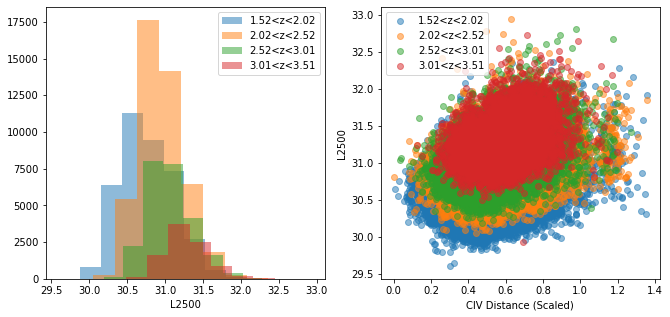

In [9]:
zbins = np.linspace(z.min(), z.max()+.01, 5)
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))
for i in range(len(zbins)-1):
    binmask = (z>=zbins[i])&(z<zbins[i+1])
    ax1.hist(L2500[binmask], alpha=0.5, label="%.2f<z<%.2f" % (zbins[i],zbins[i+1]))
    ax1.set_xlabel("L2500") ; ax1.legend(loc="best")
    ax2.scatter(CIVdist[binmask], L2500[binmask], alpha=0.5, label="%.2f<z<%.2f" % (zbins[i],zbins[i+1]))
    ax2.set_xlabel("CIV Distance (Scaled)") ; ax2.set_ylabel("L2500") ; ax2.legend(loc="best")

Text(0, 0.5, 'L2500')

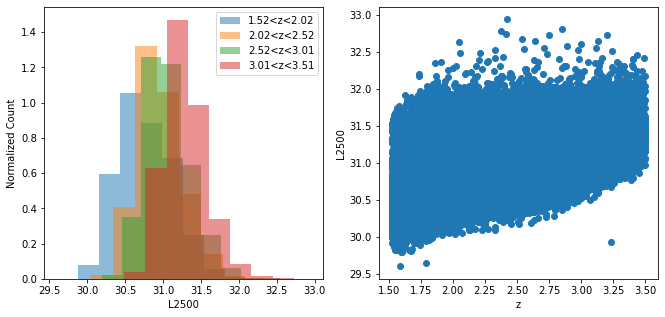

In [10]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))
for i in range(len(zbins)-1):
    binmask = (z>=zbins[i])&(z<zbins[i+1])
    ax1.hist(L2500[binmask], alpha=0.5, label="%.2f<z<%.2f" % (zbins[i],zbins[i+1]), density=True)
    ax1.set_xlabel("L2500") ; ax1.set_ylabel("Normalized Count"); ax1.legend(loc="best")
ax2.scatter(z, L2500)
ax2.set_xlabel("z") ; ax2.set_ylabel("L2500")

We're going to need to deal with this at some point.  I don't think just shifting the median L2500 in redshift bins is the right thing to do, because this looks at least partially to be a selection effect?  Now it just looks like we could remove sources near the SDSS flux limit.

For now I'll just ignore it and see how things go.

---

We kind of just need to find something to beat down this scatter.  I'll first just brute force it and colorcode CIV plots by basically everything.  Maybe clustering $ugriz$ colors could be somehow useful?

In [11]:
%matplotlib inline
def plot(x, y, c, xname="", yname="", cname=""):
    fig = plt.figure(figsize=(7,6))
    plt.scatter(x, y, alpha=0.7, c=c, cmap="nipy_spectral")#, vmin=np.percentile(c, 5), vmax=np.percentile(c, 95))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(cname)
    plt.xlabel(xname)
    plt.ylabel(yname)
    #plt.show()
    
def plot_CIV(colorprop, colorname):
    fig, [ax1,ax2,ax3,cax] = plt.subplots(1, 4, figsize=(17.5,5), gridspec_kw={"width_ratios":[1,1,1,0.03]})
    
    p1 = ax1.scatter(CIVdist, L2500, c=colorprop, vmin=np.percentile(colorprop, 2), vmax=np.percentile(colorprop, 98))
    ax1.set_xlabel("CIV Distance") ; ax1.set_ylabel("L2500")
    
    ax2.scatter(logEW, L2500, c=colorprop, vmin=np.percentile(colorprop, 2), vmax=np.percentile(colorprop, 98))
    ax2.set_xlabel("log EW") ; ax2.set_ylabel("L2500")
    
    ax3.scatter(blue, L2500, c=colorprop, vmin=np.percentile(colorprop, 2), vmax=np.percentile(colorprop, 98))
    ax3.set_xlabel("Blueshift") ; ax3.set_ylabel("L2500")
    
    cbar = fig.colorbar(p1, cax=cax)
    cbar.ax.set_ylabel(colorname)
    
    plt.show()

#plot(CIVdist[z<2.9], L2500[z<2.9], z[z<2.9], "CIV distance", "L2500", "z")

See if we can make some better cuts.  Take Gordon's 08/30/21 suggestions - take measurements where L2500 isn't as noisy.
* Can consider redshifts where 2500$Å$ is actually available - $z<3.056$ for DR14 and $z<2.68$ for DR7
* Ignore redshifts where an SDSS filter contains, e.g., both 2500$Å$ and the MgII emission line

Test the second item now.

In [12]:
!ls ../data/SDSS_Filters/

g.txt i.txt r.txt u.txt z.txt


In [13]:
ufil = pd.read_csv("../data/SDSS_Filters/u.txt", sep="\s+").values
gfil = pd.read_csv("../data/SDSS_Filters/g.txt", sep="\s+").values
rfil = pd.read_csv("../data/SDSS_Filters/r.txt", sep="\s+").values
ifil = pd.read_csv("../data/SDSS_Filters/i.txt", sep="\s+").values
zfil = pd.read_csv("../data/SDSS_Filters/z.txt", sep="\s+").values

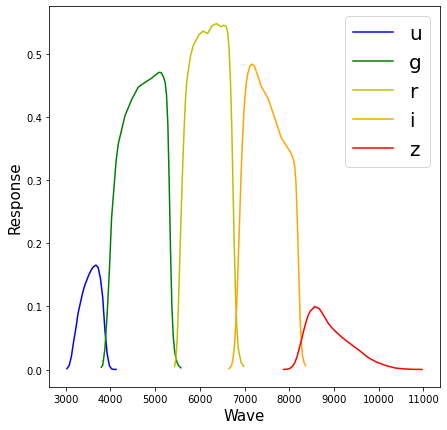

In [14]:
fig = plt.figure(figsize=(7,7))
plt.plot(ufil[:,0], ufil[:,1], color="b", label="u")
plt.plot(gfil[:,0], gfil[:,1], color="g", label="g")
plt.plot(rfil[:,0], rfil[:,1], color="y", label="r")
plt.plot(ifil[:,0], ifil[:,1], color="orange", label="i")
plt.plot(zfil[:,0], zfil[:,1], color="r", label="z")
plt.ylabel("Response", fontsize=15)
plt.xlabel("Wave", fontsize=15)
plt.legend(loc="best", prop={"size":20})
plt.show()

In [15]:
vb01 = pd.read_csv("../data/vandenberk01_medianSDSSspectrum.txt", sep="\s+").values

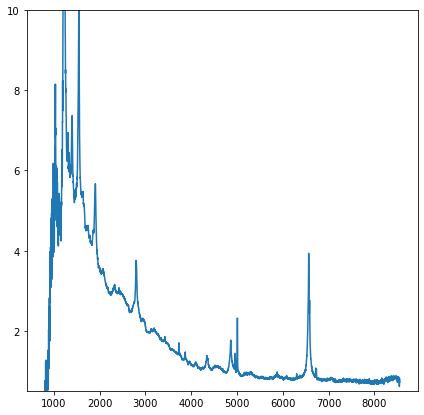

In [16]:
fig = plt.figure(figsize=(7,7))
plt.plot(vb01[:,0], vb01[:,1])
plt.ylim(0.5,10)
plt.show()

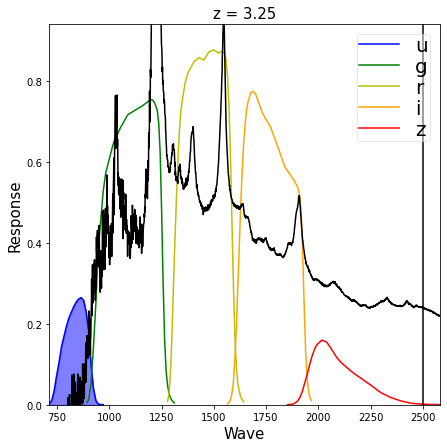

In [17]:
def plot_filters(z):
    fig = plt.figure(figsize=(7,7))
    plt.plot(ufil[:,0]/(1.+z), ufil[:,1]*1.6, color="b", label="u")
    plt.fill_between(ufil[:,0]/(1.+z), ufil[:,1]*1.6, np.zeros(len(ufil[:,1])), color="b", alpha=0.5)
    plt.plot(gfil[:,0]/(1.+z), gfil[:,1]*1.6, color="g", label="g")
    plt.plot(rfil[:,0]/(1.+z), rfil[:,1]*1.6, color="y", label="r")
    plt.plot(ifil[:,0]/(1.+z), ifil[:,1]*1.6, color="orange", label="i")
    plt.plot(zfil[:,0]/(1.+z), zfil[:,1]*1.6, color="r", label="z")
    plt.plot([2500,2500],[-0.1,1.0],"-k") #plot 2500 angstroms
    plt.plot(vb01[:,0], vb01[:,1]/10.-0.05, "-k")
    plt.ylabel("Response", fontsize=15)
    plt.xlabel("Wave", fontsize=15)
    plt.title("z = %.2f"%z, fontsize=15)
    plt.xlim(min(ufil[:,0]/(1+z)),max(zfil[:,0]/(1+z)))
    plt.ylim(0,0.94)
    plt.legend(loc="upper right", prop={"size":20}, framealpha=0.5, labelspacing=0.1, borderpad=0.1)
    #plt.show()
plot_filters(3.25)

<ipython-input-17-583e7a3eb932>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(7,7))


<Figure size 504x504 with 0 Axes>

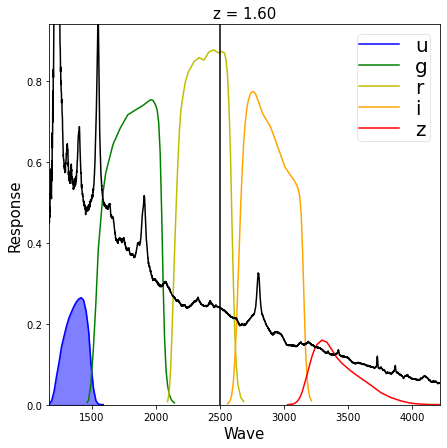

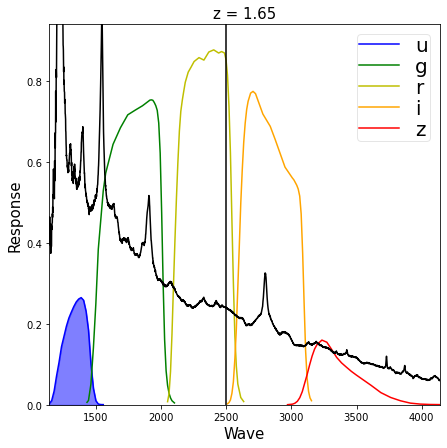

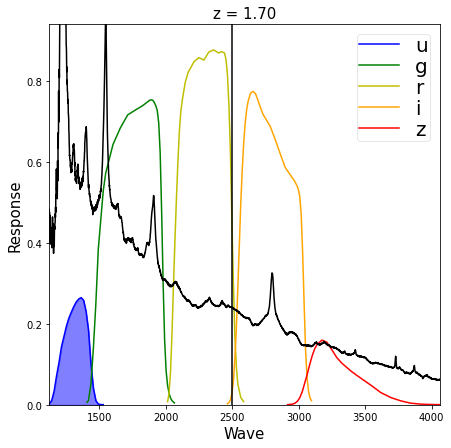

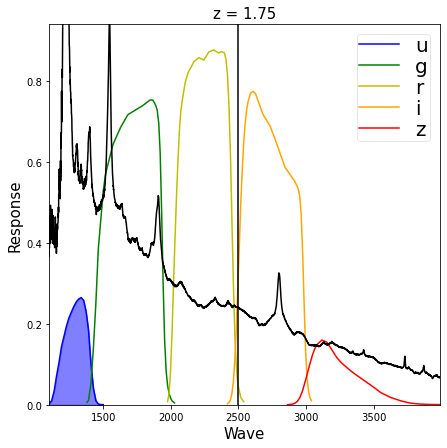

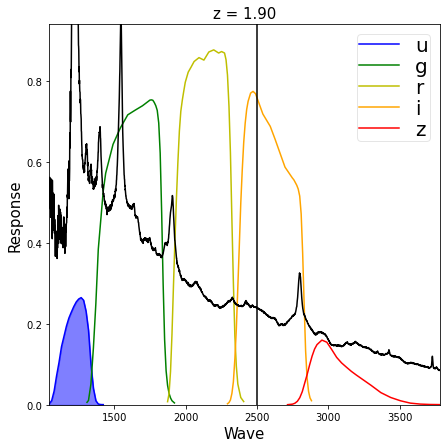

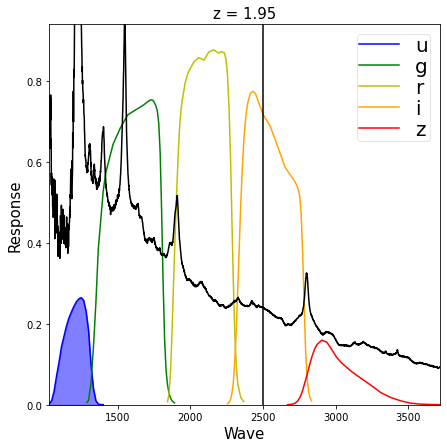

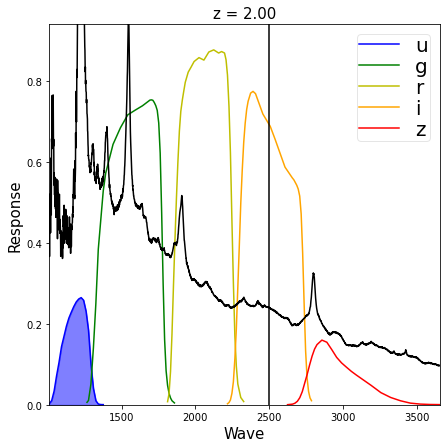

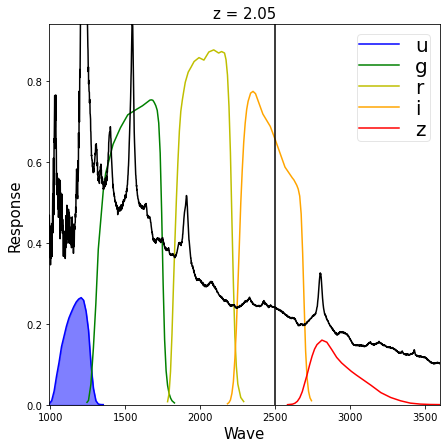

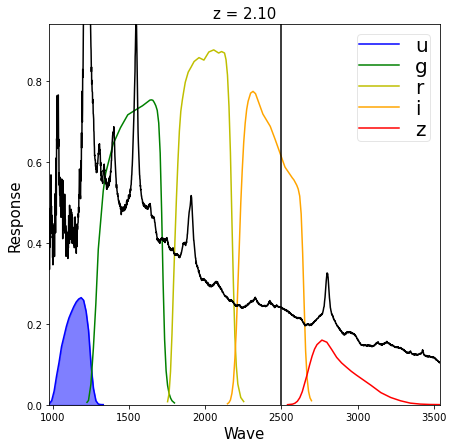

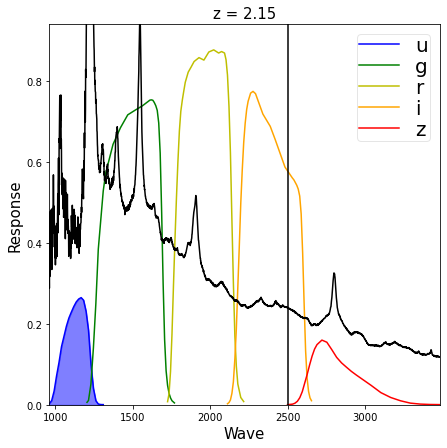

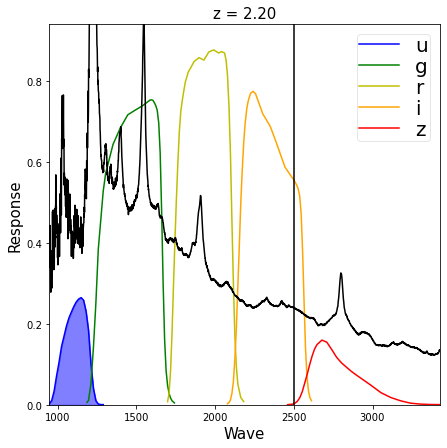

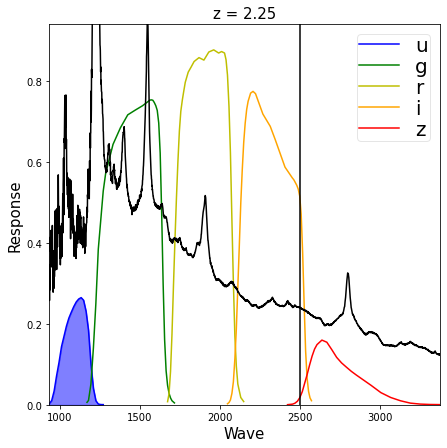

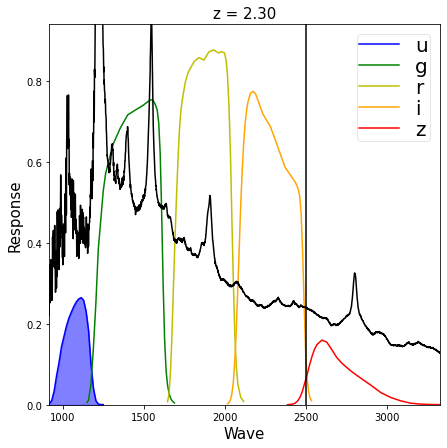

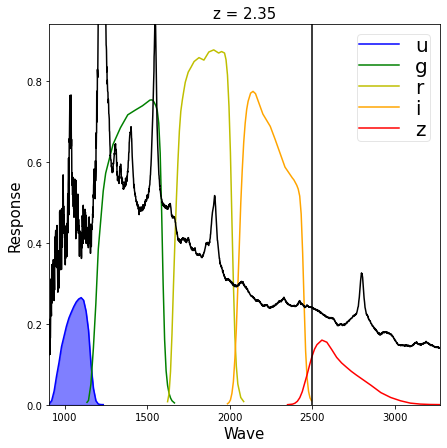

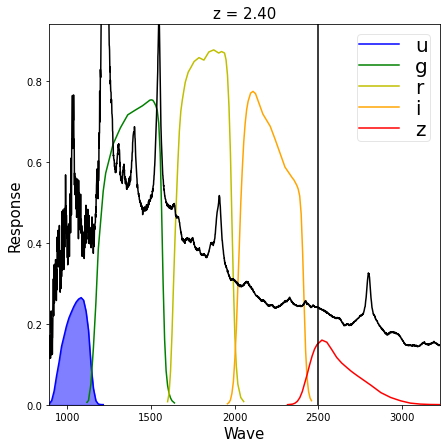

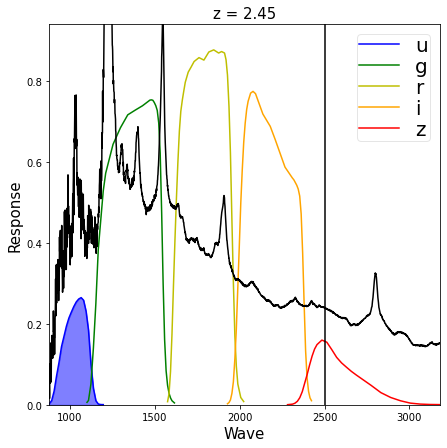

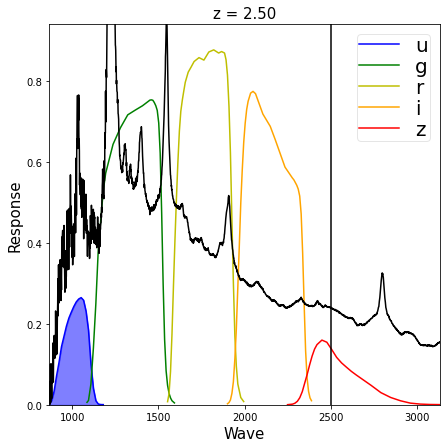

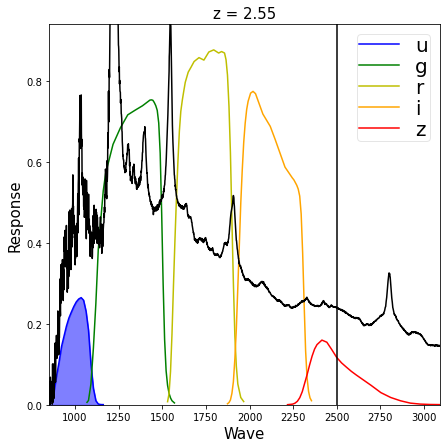

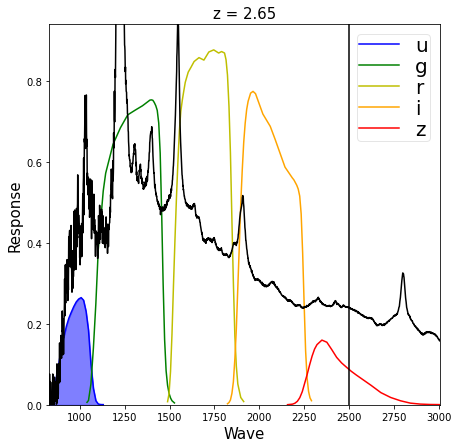

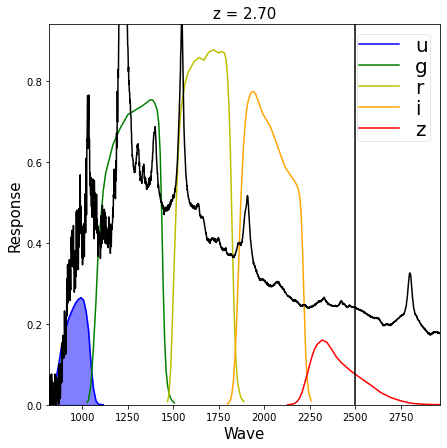

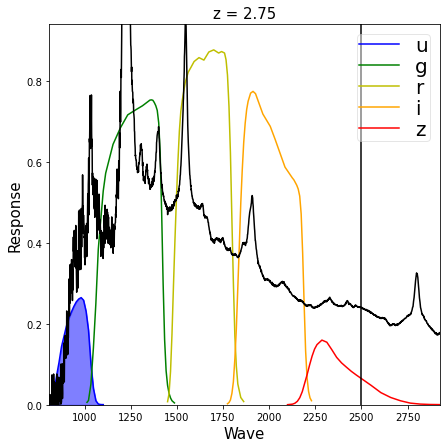

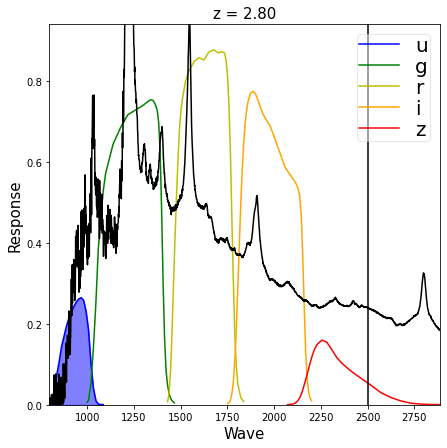

In [18]:
fig = plt.figure(figsize=(7,7))
for zz in np.arange(1.6, 2.7+0.1, 0.05):
    plot_filters(zz)

We can use the following redshift ranges to avoid the MgII line in 2500Å measurements:
* $1.6 < z < 1.7$
* $2.0 < z < 2.25$
* $2.4 < z < 2.65$

In [19]:
((z>=1.6)&(z<=1.7))

array([False,  True, False, ...,  True, False, False])

In [20]:
!ls

AllXRayData.071221.fits
AllXRayData.fits
AllXRayData_GTR.fits
CIVDistBokehGTR.070521.html
CIVDistBokehGTR.html
CIVDistBokehGTR_logCIVEW.html
CIVDistsBokehGTR.070521.ipynb
CIVDistsBokehGTR_trevor.ipynb
CIV_amy_scaled_linear.npy
CIV_amy_scaled_log.npy
F2500_dr14.ipynb
F2500_dr16.ipynb
L2500_CIVprops_plots_3.ipynb
L2500_CIVprops_plots_4.ipynb
L2500_CIVprops_plots_5.ipynb
Untitled.ipynb
anastasia
aoxL2500
filters_2500A_MgII.ipynb
filters_2500A_MgII.py
gamma_daox_diagonal_corrs-Copy1.ipynb
gamma_daox_diagonal_corrs.ipynb
gamma_daox_diagonal_corrs_plots.ipynb
gamma_daox_diagonal_corrs_plots_2.ipynb
gamma_daox_diagonal_corrs_shiftdaox.ipynb
gamma_daox_diagonal_corrs_shiftdaox_2.ipynb
gamma_daox_diagonal_corrs_shiftdaox_3.ipynb
gamma_daox_diagonal_corrs_shiftdaox_4_mean.ipynb
gamma_daox_diagonal_corrs_shiftdaox_4_mean_clean.ipynb
gamma_daox_diagonal_corrs_shiftdaox_4_mean_clean_2.ipynb
gamma_daox_diagonal_corrs_shiftdaox_4_mean_clean_3_linfits.ipynb
gamma_daox_diagonal_corrs_shiftdaox_4_mean_c

In [21]:
goodz = ((z>=1.6)&(z<=1.7)) | ((z>=2.0)&(z<=2.25)) | ((z>=2.4)&(z<=2.65))
#goodz = ((z>=1.6)&(z<=1.7)) | ((z>=2.0)&(z<=2.25)) | ((z>=2.4)&(z<=3.05))

fig = plt.figure(figsize=(6,6))
plt.scatter(CIVdist, L2500, alpha=0.5)
plt.scatter(CIVdist[goodz], L2500[goodz], alpha=0.5)
plt.ylabel("L2500")
plt.xlabel("CIV Distance")
plt.tight_layout()
plt.savefig("plots/L2500_vs_CIVdist_2500A_noMgII.png")
plt.show()

In [22]:
print(goodz.sum(), len(dat))

49050 118259


Looks better, but how much of that is from "noise" from the MgII line?  See what happens when we just take redshifts that include 2500Å.

In [23]:
fig = plt.figure(figsize=(6,6))
plt.scatter(CIVdist, L2500, alpha=0.5)
plt.scatter(CIVdist[z<=2.68], L2500[z<=2.68], alpha=0.5)
plt.ylabel("L2500")
plt.xlabel("CIV Distance")
plt.tight_layout()
plt.savefig("plots/L2500_vs_CIVdist_zlt2.68.png")
plt.show()

So the MgII line actually does cause a fair bit of noise.  It cuts down the scatter to avoid redshifts where it contributes, but we lose more than half of our objects in the process.  If it's doable, spectral flux measurements will be the way to go.

In [24]:
ugriz[goodz].shape

(49050, 5)

In [25]:
dat = dat[goodz]
ugriz = ugriz[goodz]

Mi     = dat["MI"].values
d      = 3.08e19 #cm; =10pc
L2500  = -0.4*( Mi + 48.60 + np.log10(1+2) ) + np.log10(4*np.pi*(d**2)) #Eq 4 from Richards+ 2006, QLF paper
del_gi = dat["Delta_G_I"].values
blue   = dat["CIV_blue"].values
ew     = dat["CIV_EW"].values
z      = dat["z_paul"].values
logEW  = np.log10(ew)
HeIIEW = dat["HeII_EW"].values
CIVdist= dat["CIV_Distance"].values

---

Not much here, so let's see if we can put the modal colors to use.

In [26]:
colors = {
    "u-g": ugriz[:,0]-ugriz[:,1],
    "g-r": ugriz[:,1]-ugriz[:,2],
    "r-i": ugriz[:,2]-ugriz[:,3],
    "i-z": ugriz[:,3]-ugriz[:,4]
}

dcolors = {
    "d_ug": [],
    "d_gr": [],
    "d_ri": [],
    "d_iz": []
}

In [27]:
modal_cols = pd.read_csv("/Users/Trevor1/Desktop/git/Cosmology_Quasars/data/dr16qsocat_czrSF11.061821.dat", sep=" ") #from Gordon
zmean = modal_cols["zmean"].values
ugmode = modal_cols["ugmode"].values
grmode = modal_cols["grmode"].values
rimode = modal_cols["rimode"].values
izmode = modal_cols["izmode"].values
modal_cols.head()

#zbin  zmean  nqsos  gimode  ugmode  grmode  rimode  izmode
0   0.10  0.105    227   0.804   0.301   0.347   0.457   0.057
1   0.14  0.141    292   0.738   0.208   0.315   0.424   0.016
2   0.17  0.172    425   0.696   0.135   0.317   0.402   0.010
3   0.19  0.190    177   0.615  -0.054   0.222   0.378  -0.004
4   0.20  0.200    199   0.678   0.009   0.320   0.372   0.039

Find the following for each quasar:

* $\Delta(u-g)$
* $\Delta(g-r)$
* $\Delta(r-i)$
* $\Delta(i-z)$

In [28]:
for i in range(len(dat)):
    ind_z = np.abs(z[i]-modal_cols["zmean"].values).argmin() #find which modal color zbin to use for each quasar
    dcolors["d_ug"].append( colors["u-g"][i]-ugmode[ind_z] )
    dcolors["d_gr"].append( colors["g-r"][i]-grmode[ind_z] )
    dcolors["d_ri"].append( colors["r-i"][i]-rimode[ind_z] )
    dcolors["d_iz"].append( colors["i-z"][i]-izmode[ind_z] )

Plot them to make sure they make sense.

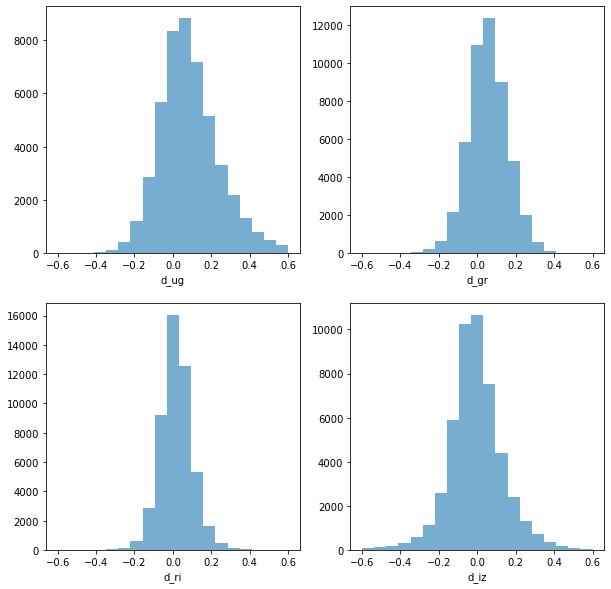

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i in range(len(colors)):
    #print(i//2,i%2)
    axs[i//2,i%2].hist(dcolors[list(dcolors.keys())[i]], bins=np.linspace(-0.6,0.6,20), alpha=0.6)
    axs[i//2,i%2].set_xlabel(list(dcolors.keys())[i])
plt.show()

Look good.  Now try color-coding as above.

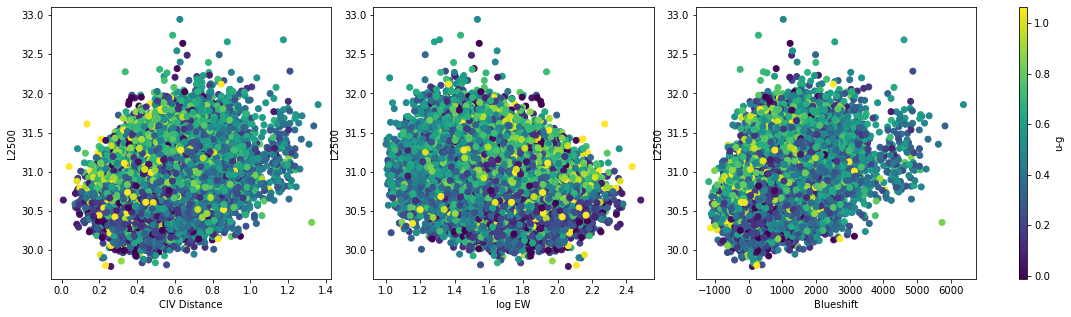

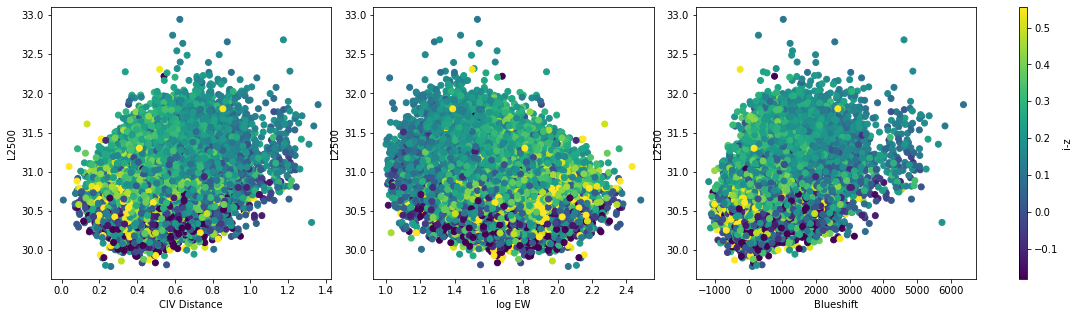

In [30]:
for i in range(len(colors)):
    plot_CIV(colors[list(colors.keys())[i]], list(colors.keys())[i])

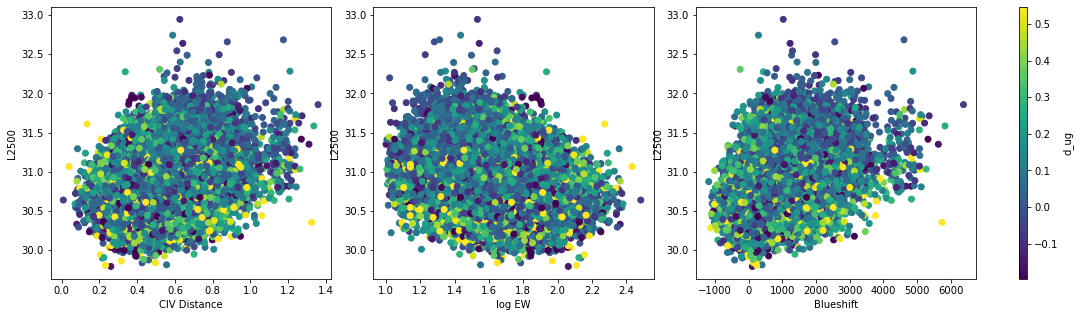

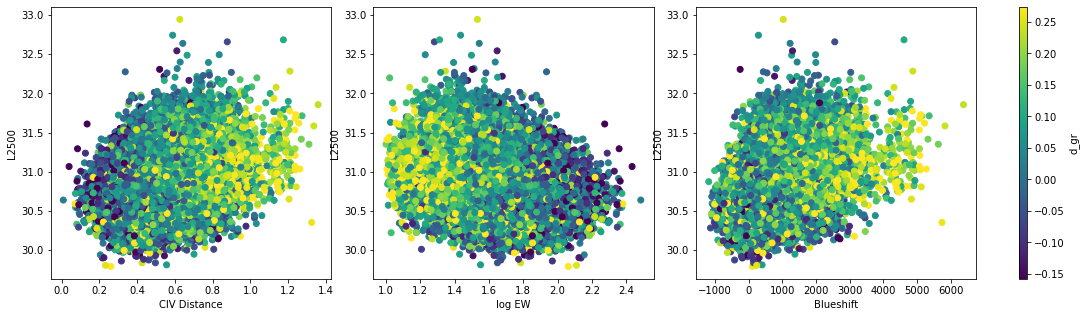

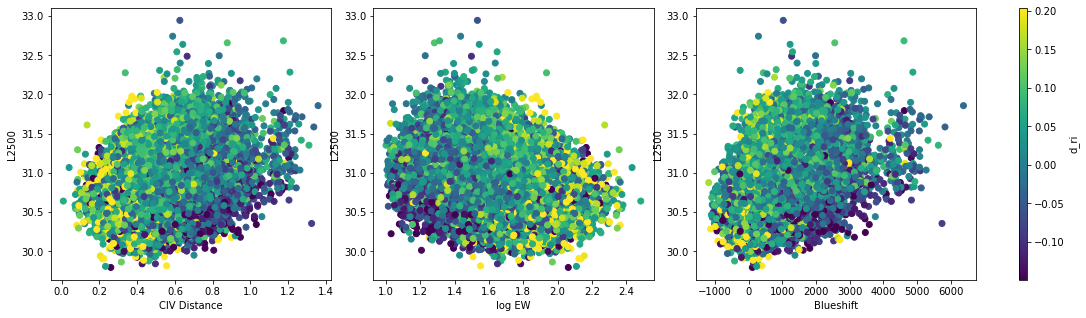

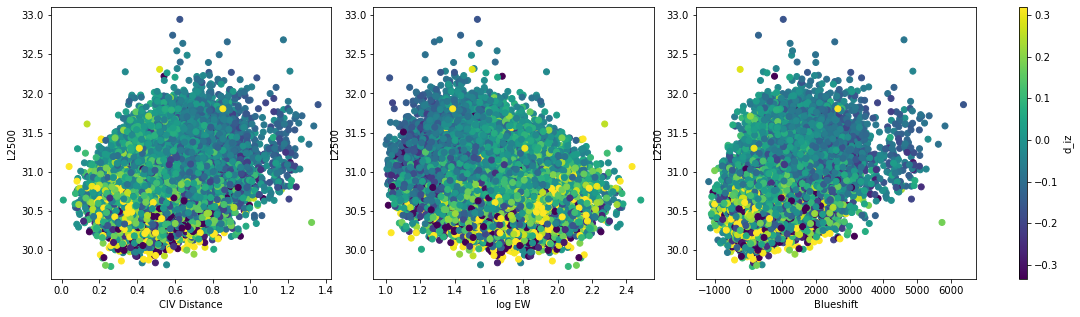

In [31]:
for i in range(len(dcolors)):
    plot_CIV(dcolors[list(dcolors.keys())[i]], list(dcolors.keys())[i])

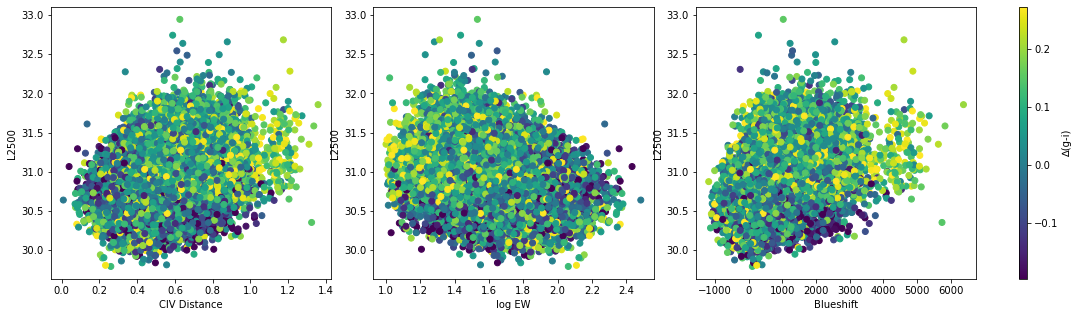

In [32]:
plot_CIV(del_gi, "∆(g-i)")

Looks like maybe $\Delta(g-r)$ could be useful.  Might be useful to split these up even more than we have already.  That is, also computing $\Delta(u-r)$, $\Delta(g-z)$, etc.  But to do that we'll need those modal colors as a function of redshift as well.

Maybe throwing some clustering algorithms at these could be useful too?  If nothing else, it's worth trying to define discrete subsamples we can apply corrections to.

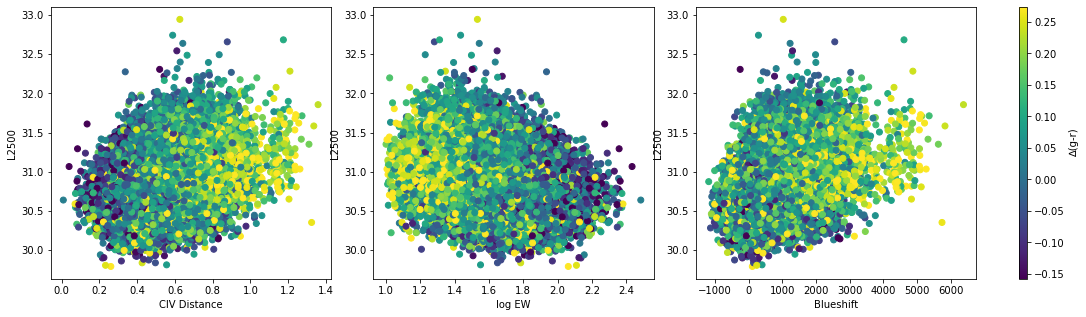

In [33]:
plot_CIV(dcolors["d_gr"], "∆(g-r)")

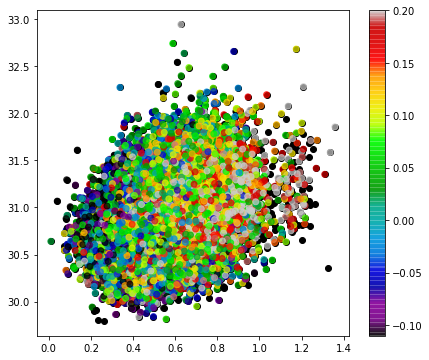

In [34]:
def plot(x, y, c, xname="", yname="", cname=""):
    fig = plt.figure(figsize=(7,6))
    plt.scatter(x, y, alpha=0.7, c=c, cmap="nipy_spectral", zorder=2, vmin=np.percentile(c, 5), vmax=np.percentile(c, 95))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(cname)
    plt.xlabel(xname)
    plt.ylabel(yname)
    #plt.show()

mask = np.array(dcolors["d_gr"])<0.25
plot(CIVdist[mask], L2500[mask], np.array(dcolors["d_gr"])[mask], xname="", yname="", cname="")
plt.scatter(CIVdist, L2500, color="k")

In [35]:
def polyfit(xdata, ydata, xrange=None):
    #perform np.polyfit 
    m, b = np.polyfit(xdata, ydata, 1)
    x = np.arange(min(xdata), max(xdata), (max(xdata)-min(xdata))/5000) if xrange is None else xrange
    y = m*x + b
    return np.array([x,y]).T

def even_fit(xdata, ydata, xrange=None):
    #Fit x vs y, then y vs x, and take the bisection of those two fits
    m1,b1 = np.polyfit(ydata, xdata, 1)
    x1 = np.linspace(ydata.min(),ydata.max(),500)
    y1 = m1*x1 + b1
    
    m2,b2 = np.polyfit(xdata, ydata, 1)
    x2 = np.linspace(xdata.min(),xdata.max(),500)
    y2 = m2*x2 + b2
    
    #Clip before determining scaling
    xdata_clipped = sigma_clip(xdata, sigma=3, maxiters=10, masked=False)
    ydata_clipped = sigma_clip(ydata, sigma=3, maxiters=10, masked=False)
    clip_mask = ((xdata>=xdata_clipped.min()) & (xdata<=xdata_clipped.max())) & ((ydata>=ydata_clipped.min()) & (ydata<=ydata_clipped.max()))
    
    #Format for sklearn scalers
    data = np.array([xdata, ydata]).T
    data_clip = np.array([xdata[clip_mask], ydata[clip_mask]]).T
    fit1 = np.array([y1, x1]).T
    fit2 = np.array([x2, y2]).T
    
    #Fit scaler on clipped data, then transform all data
    scaler = MinMaxScaler().fit(data_clip)
    data_scaled = scaler.transform(data)
    fit1_scale = scaler.transform(fit1)
    fit2_scale = scaler.transform(fit2)
    
    #Get point of intersection for two lines above
    intfit_x_scaled, intfit_y_scaled = line_intersection(fit1_scale, fit2_scale)

    #The slopes of the fits in scaled space
    m1_scale = lin_slope(fit1_scale)
    m2_scale = lin_slope(fit2_scale)

    #Get the slope splitting the angle between slopes in half - see https://www.mathstopia.net/coordinate-geometry/angle-two-lines
    phi = np.arctan((m1_scale-m2_scale)/(1+m1_scale*m2_scale))
    m_new_scaled = (m1_scale-np.tan(phi/2)) / (1+m1_scale*np.tan(phi/2))
    b_new_scaled = intfit_y_scaled - intfit_x_scaled*m_new_scaled
    x_new_scaled = np.linspace(data_scaled[:,0].min(), data_scaled[:,0].max(), 1000) if xrange is None else xrange
    y_new_scaled = m_new_scaled*x_new_scaled + b_new_scaled
    fit_new_scaled = np.array([x_new_scaled, y_new_scaled]).T

    #reverse back into normal coordinates and return fit
    fit_new = scaler.inverse_transform(fit_new_scaled)
    return fit_new

def lin_slope(line):
    #return slope of a linear fit
    return (line[1,1]-line[0,1])/(line[1,0]-line[0,0])

def line_intersection(line1, line2):
    #Get the x-y intersection of two line segments
    
    #Only care about the endpoints
    line1 = ( (line1[0,0], line1[0,1]), (line1[-1,0], line1[-1,1]) )
    line2 = ( (line2[0,0], line2[0,1]), (line2[-1,0], line2[-1,1]) )
    
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


def project_pt(pt, fit):
    #Get location of a point's orthogonal projection onto a fit
    r2 = (pt[1]-fit[:,1])**2 + (pt[0]-fit[:,0])**2
    return np.array((fit[r2.argmin(),0], fit[r2.argmin(),1]))


def perp_distance(data, xax, yax):
    #Find the distance (with sign) of each point from the yaxis
        
    disty = []
    #distx = []
    #abs_disty = []
    #abs_distx = []
    int_x, int_y = line_intersection(xax, yax) #intersection of the two new axes (the "origin")
    
    for i in range(len(data)):
        r_y = np.sqrt( (data[i,0] - yax[:,0])**2 + (data[i,1] - yax[:,1])**2 ) #dist of point i from y and x axes
        #r_x = np.sqrt( (data[i,0] - xax[:,0])**2 + (data[i,1] - xax[:,1])**2 )
        #abs_disty.append(min(r_y)) ; abs_distx.append(min(r_x))
        
        #Get which side the of the line the point is on 
        proj_x = project_pt(data[i,:], xax) #project data onto new x axis 
        side_y = 1 if (proj_x[0]>=int_x) else -1
        disty.append(side_y*min(r_y))
        
    return np.array(disty)

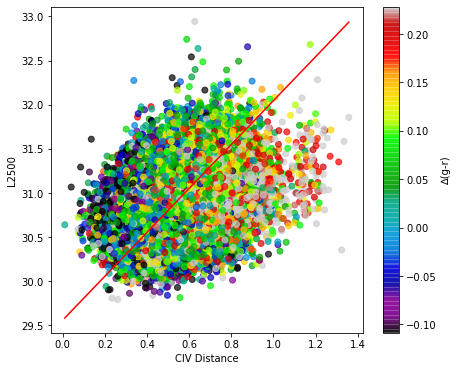

In [36]:
yax = even_fit(CIVdist, L2500)
plot(CIVdist, L2500, np.array(dcolors["d_gr"]), xname="CIV Distance", yname="L2500", cname="∆(g-r)")
plt.plot(yax[:,0], yax[:,1], "-r")

In [37]:
np.isnan(L2500).any()

False

In [38]:
def argmedian(data):
    return np.argsort(data)[len(data)//2]

#yax    = fit.copy()
indmed = argmedian(yax[:,1]) #get index where gamma is median - just for visual purposes
data   = np.array([CIVdist,L2500]).T

#Create and fit the scaler
scaler     = MinMaxScaler().fit(data)
data_scale = scaler.transform(data)
yax_scale  = scaler.transform(yax)

#Create a perpendicular axis in the scaled space
x_perp_scale = np.linspace(-.05, 1.05, 500)
m_perp_scale = -1 / lin_slope(yax_scale)
xi, yi = yax_scale[indmed,:]
b_perp_scale = yi - m_perp_scale*xi
xax_scale = np.array( [ x_perp_scale, m_perp_scale*x_perp_scale + b_perp_scale ] ).T
xax = scaler.inverse_transform(xax_scale)

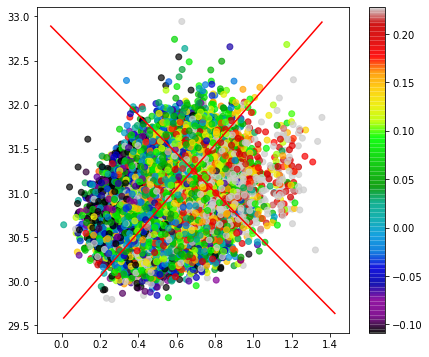

In [39]:
plot(CIVdist, L2500, np.array(dcolors["d_gr"]), xname="", yname="", cname="")
plt.plot(yax[:,0], yax[:,1], "-r")
plt.plot(xax[:,0], xax[:,1], "-r")

Find distance from the new y-axis of all points, then plot as a function of $\Delta(g-r)$

In [40]:
dist_yax_scaled = perp_distance(data_scale, xax_scale, yax_scale)

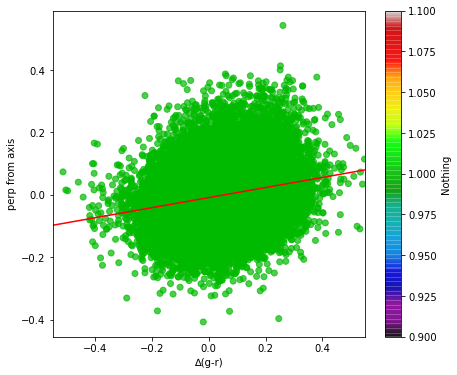

In [41]:
fitperp    = polyfit(dcolors["d_gr"], dist_yax_scaled)
#fitperp = even_fit(np.array(dcolors["d_gr"]), dist_yax_scaled, xrange=np.linspace(0.05,0.9,100))

plot(np.array(dcolors["d_gr"]), dist_yax_scaled, np.ones(len(CIVdist)), "∆(g-r)", "perp from axis", "Nothing")
plt.xlim(-0.55,0.55)
plt.plot(fitperp[:,0], fitperp[:,1], "-r")

Now shift accordingly

In [42]:
def diag_shift(data, line, mag_shift):
    data_proj = project_pt(data, line)
    rvec = np.array((data_proj[0]-data[0], data_proj[1]-data[1]))
    rmag = np.linalg.norm(rvec)
    rhat = rvec / rmag
    return data + mag_shift*rhat

In [43]:
data_shift_scale = []
for i in range(len(dcolors["d_gr"])):
    #Get index of the fitted CIV distance of point
    indperp = abs(dcolors["d_gr"][i]-fitperp[:,0]).argmin()
    perpshift = fitperp[indperp,1]
    data_shifted = diag_shift(data_scale[i,:], yax_scale, abs(perpshift))
    data_shift_scale.append(data_shifted)
data_shift_scale = np.array(data_shift_scale)
data_shift = scaler.inverse_transform(data_shift_scale)

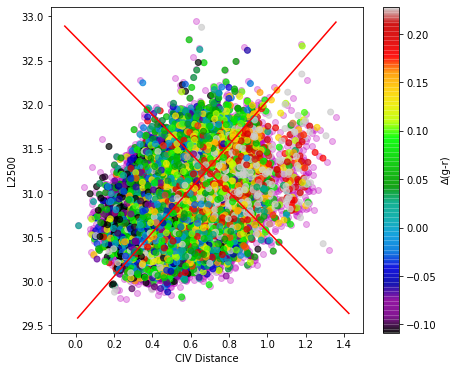

In [44]:
plot(data_shift[:,0], data_shift[:,1], np.array(dcolors["d_gr"]), "CIV Distance", "L2500", "∆(g-r)")
plt.scatter(CIVdist, L2500, color="m", alpha=0.3, zorder=1)
plt.plot(yax[:,0], yax[:,1], "-r")
plt.plot(xax[:,0], xax[:,1], "-r")

In [45]:
polyfit?

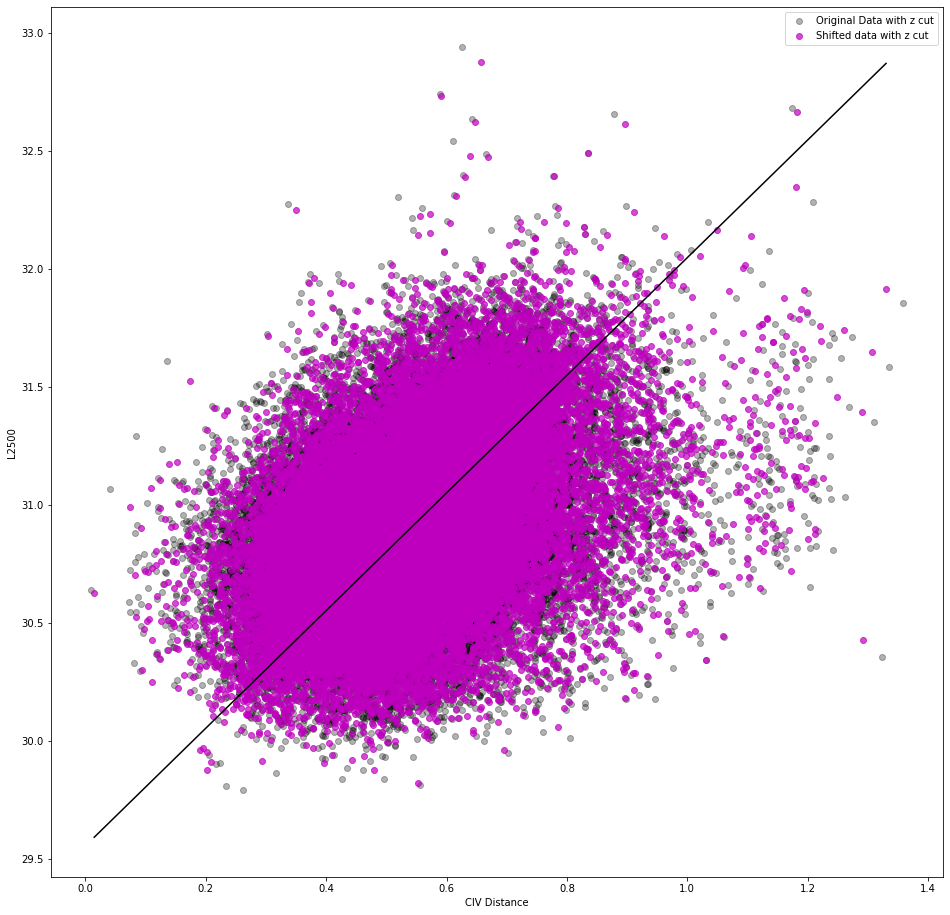

In [46]:
fit = even_fit(data_shift[:,0], data_shift[:,1])
fig = plt.figure(figsize=(16,16))
plt.scatter(CIVdist, L2500, color="k", alpha=0.3, zorder=1, label="Original Data with z cut")
plt.scatter(data_shift[:,0], data_shift[:,1], color="m", alpha=0.7, zorder=1, label="Shifted data with z cut")
plt.plot(fit[:,0], fit[:,1], "-k", zorder=2)
plt.xlabel("CIV Distance")
plt.ylabel("L2500")
plt.legend(loc="best")
plt.show()